In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [3]:
# Define custom accuracy metric for regression
def custom_accuracy(y_true, y_pred):
    threshold = 0.6  # Adjust the threshold based on your needs
    diff = K.abs(y_true - y_pred)
    correct = K.less(diff, threshold)
    return K.mean(correct, axis=-1)


In [4]:
# Load data
train_data = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
test_data = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")
oil_data = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
holidays_data = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")
stores_data = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
transaction_data = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")


In [5]:
# Merge data
merged_data = pd.merge(train_data, stores_data, on='store_nbr', how='left')
merged_data = pd.merge(merged_data, oil_data, on='date', how='left')
merged_data = pd.merge(merged_data, holidays_data, on='date', how='left')
merged_data = pd.merge(merged_data, transaction_data, on=['date', 'store_nbr'], how='left')
merged_data = merged_data.drop(columns=['date'])
merged_data = merged_data.drop(columns=['id'])
merged_data = merged_data.drop(columns=['description'])
merged_data = merged_data.drop(columns=['transferred'])
merged_data = merged_data.dropna()
#type_y locale locale_name  transactions
columns_to_drop = [ 'type_y', 'locale', 'locale_name', 'transactions']
merged_data = merged_data.drop(columns=columns_to_drop)

print(merged_data)
m = np.mean(merged_data["sales"])
s = np.std(merged_data["sales"])
print(m)
print(s)




         store_nbr                      family     sales  onpromotion   city  \
73062            1                  AUTOMOTIVE     0.000            0  Quito   
73063            1                   BABY CARE     0.000            0  Quito   
73064            1                      BEAUTY     0.000            0  Quito   
73065            1                   BEVERAGES   172.000            0  Quito   
73066            1                       BOOKS     0.000            0  Quito   
...            ...                         ...       ...          ...    ...   
3054343          9                     POULTRY   438.133            0  Quito   
3054344          9              PREPARED FOODS   154.553            1  Quito   
3054345          9                     PRODUCE  2419.729          148  Quito   
3054346          9  SCHOOL AND OFFICE SUPPLIES   121.000            8  Quito   
3054347          9                     SEAFOOD    16.000            0  Quito   

             state type_x  cluster  dco

In [6]:
# Merge data
merged_test = pd.merge(test_data, stores_data, on='store_nbr', how='left')
merged_test = pd.merge(merged_test, oil_data, on='date', how='left')
merged_test = pd.merge(merged_test, holidays_data, on='date', how='left')
merged_test = pd.merge(merged_test, transaction_data, on=['date', 'store_nbr'], how='left')
id=merged_test["id"]
# Drop unnecessary columns
columns_to_drop = ['date', 'id', 'description', 'transferred']
merged_test = merged_test.drop(columns=columns_to_drop)
columns_to_drop = [ 'type_y', 'locale', 'locale_name', 'transactions']
merged_test = merged_test.drop(columns=columns_to_drop)

# Fill missing values in columns with appropriate strategies
# For example, filling missing values in 'dcoilwtico' with the median value
merged_test['dcoilwtico'] = merged_test['dcoilwtico'].fillna(merged_test['dcoilwtico'].median())
merged_test=merged_test.dropna()


print(merged_test)

       store_nbr                      family  onpromotion   city      state  \
0              1                  AUTOMOTIVE            0  Quito  Pichincha   
1              1                   BABY CARE            0  Quito  Pichincha   
2              1                      BEAUTY            2  Quito  Pichincha   
3              1                   BEVERAGES           20  Quito  Pichincha   
4              1                       BOOKS            0  Quito  Pichincha   
...          ...                         ...          ...    ...        ...   
28507          9                     POULTRY            1  Quito  Pichincha   
28508          9              PREPARED FOODS            0  Quito  Pichincha   
28509          9                     PRODUCE            1  Quito  Pichincha   
28510          9  SCHOOL AND OFFICE SUPPLIES            9  Quito  Pichincha   
28511          9                     SEAFOOD            0  Quito  Pichincha   

      type_x  cluster  dcoilwtico  
0          D   

In [7]:


# Apply label encoding for categorical columns
label_encoder = LabelEncoder()
categorical_cols = ['family', 'city', 'state', 'type_x']
for col in categorical_cols:
    merged_data[col] = label_encoder.fit_transform(merged_data[col])

# Scale numerical columns using StandardScaler
scaler = StandardScaler()
numerical_cols = ['sales', 'onpromotion', 'cluster', 'dcoilwtico']
merged_data[numerical_cols] = scaler.fit_transform(merged_data[numerical_cols])

# Features and target
X = merged_data.drop('sales', axis=1)
Y = merged_data['sales']



In [8]:
# Apply label encoding for categorical columns
label_encoder = LabelEncoder()
categorical_cols = ['family', 'city', 'state', 'type_x']
for col in categorical_cols:
    merged_test[col] = label_encoder.fit_transform(merged_test[col])


scaler = StandardScaler()
numerical_cols = [ 'onpromotion', 'cluster', 'dcoilwtico']
merged_test[numerical_cols] = scaler.fit_transform(merged_test[numerical_cols])

print(merged_test)

       store_nbr  family  onpromotion  city  state  type_x   cluster  \
0              1       0    -0.336759    18     12       3  0.971780   
1              1       1    -0.336759    18     12       3  0.971780   
2              1       2    -0.240064    18     12       3  0.971780   
3              1       3     0.630191    18     12       3  0.971780   
4              1       4    -0.336759    18     12       3  0.971780   
...          ...     ...          ...   ...    ...     ...       ...   
28507          9      28    -0.288411    18     12       1 -0.533682   
28508          9      29    -0.336759    18     12       1 -0.533682   
28509          9      30    -0.288411    18     12       1 -0.533682   
28510          9      31     0.098369    18     12       1 -0.533682   
28511          9      32    -0.336759    18     12       1 -0.533682   

       dcoilwtico  
0       -0.681567  
1       -0.681567  
2       -0.681567  
3       -0.681567  
4       -0.681567  
...           .

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Define and compile the model
reg_dropout_model = Sequential()

# Add the first dense layer with L2 regularization and dropout
input_shape = X_train.shape[1]  # Number of features
reg_dropout_model.add(Dense(64, input_shape=(input_shape,), activation='relu', kernel_regularizer=l2(0.001)))
reg_dropout_model.add(Dropout(0.5))  # Adding dropout for regularization

# Add the second dense layer with L2 regularization and dropout
reg_dropout_model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
reg_dropout_model.add(Dropout(0.5))  # Adding dropout for regularization

# Add the output layer with linear activation (no activation for regression)
reg_dropout_model.add(Dense(1, activation='linear', kernel_regularizer=l2(0.001)))

# Compile the model with mean squared error loss, Adam optimizer, and custom accuracy metric
optimizer = Adam(learning_rate=0.0001)  # Adjusted learning rate
reg_dropout_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[custom_accuracy])

# Train the model
history = reg_dropout_model.fit(
    X_train, y_train,
    epochs=2, batch_size=32,
    validation_data=(X_test, y_test),
)

reg_dropout_model.summary()


Epoch 1/2
6563/6563 [==============================] - 20s 3ms/step - loss: 3.5710 - custom_accuracy: 0.6246 - val_loss: 1.1091 - val_custom_accuracy: 0.9125
Epoch 2/2
6563/6563 [==============================] - 20s 3ms/step - loss: 0.9967 - custom_accuracy: 0.8868 - val_loss: 1.0696 - val_custom_accuracy: 0.9110
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 den

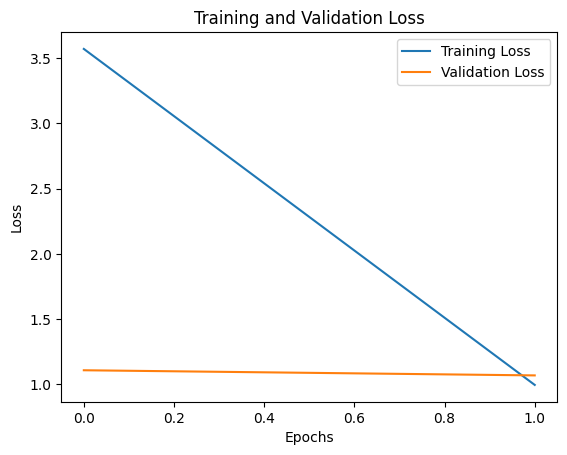

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:

# Make predictions on the test data using the trained model
predicted_output = reg_dropout_model.predict(merged_test)

# You can use the predicted_output for further analysis or submission
print(predicted_output)

891/891 [==============================] - 1s 2ms/step
[[ 0.06303919]
 [ 0.05922852]
 [ 0.05806536]
 ...
 [-0.09080004]
 [-0.09080004]
 [-0.09080004]]


In [12]:
p=(predicted_output * s) + m
predicted_df = pd.DataFrame({'sales': p.flatten()})
test_data_final = pd.concat([id, predicted_df['sales']], axis=1)
test_data_final.to_csv('model.csv', index=False)

Epoch 1/2
6563/6563 [==============================] - 68s 10ms/step - loss: 0.6552 - val_loss: 0.5534
Epoch 2/2
2813/2813 [==============================] - 10s 4ms/step - loss: 0.4262
Test Loss: 0.42621102929115295
2813/2813 [==============================] - 10s 3ms/step
Mean Squared Error: 0.426210851946662


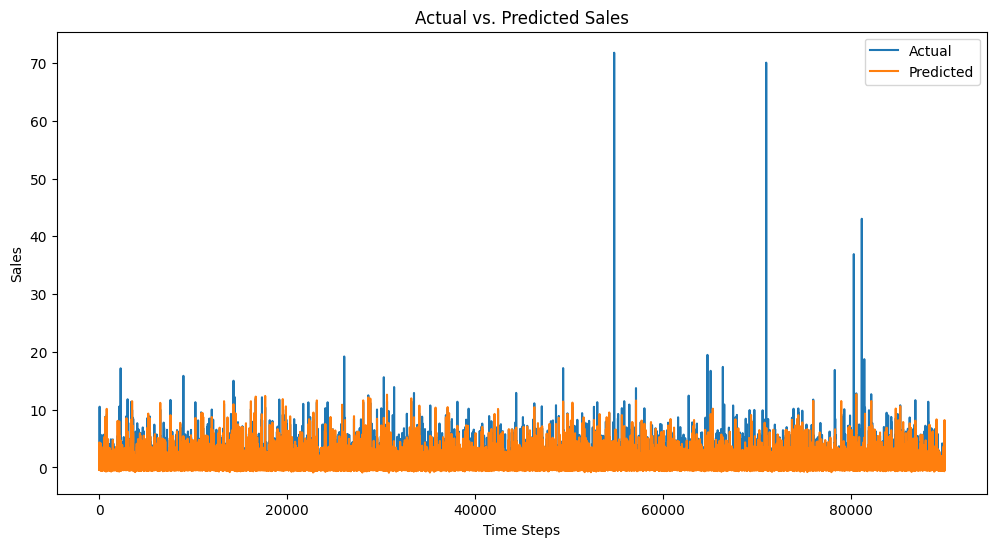

In [13]:
def reshape_for_lstm(data, time_steps):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(x), np.array(y)

# Extract the sales column as the target variable
y_series = merged_data['sales'].values

# Feature scaling
scaler = StandardScaler()
y_series = scaler.fit_transform(y_series.reshape(-1, 1)).flatten()

# Create sequences for time series forecasting
time_steps = 10
X_series, Y_series = reshape_for_lstm(y_series, time_steps)

# Reshape X_series to include the number of features
X_series = X_series.reshape(X_series.shape[0], X_series.shape[1], 1)

# Split the data into training and testing sets
X_train_series, X_test_series, y_train_series, y_test_series = train_test_split(
    X_series, Y_series, test_size=0.3, random_state=42
)

# Define and compile the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Use EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the LSTM model
history = lstm_model.fit(
    X_train_series, y_train_series,
    epochs=2, batch_size=32,
    validation_data=(X_test_series, y_test_series),
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss = lstm_model.evaluate(X_test_series, y_test_series)
print(f"Test Loss: {test_loss}")

# Make predictions on the test data using the trained LSTM model
predicted_series = lstm_model.predict(X_test_series)

# Inverse transform the predictions to the original scale
predicted_series = scaler.inverse_transform(predicted_series)
y_test_series_original = scaler.inverse_transform(y_test_series.reshape(-1, 1))

# Evaluate performance (you can use different metrics as needed)
mse = mean_squared_error(y_test_series_original, predicted_series)
print(f"Mean Squared Error: {mse}")

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_series_original, label='Actual')
plt.plot(predicted_series, label='Predicted')
plt.title('Actual vs. Predicted Sales')
plt.xlabel('Time Steps')
plt.ylabel('Sales')
plt.legend()
plt.show()